## 1) Since the time unit (day, month, year) varies from dataset to dataset, make your code agnostic of the input. In other words, have your code to determine the unit of the time series. 

In [188]:
import pandas as pd, os, numpy as np, sys, matplotlib.pyplot as plt
from fbprophet import Prophet
from datetime import datetime

In [189]:
global_dic = {}
for thefile in os.listdir(r'sample_data'):
  if 'SN_' in thefile:
    df = pd.read_csv(r'sample_data/{thefile}'.format(thefile=thefile),header=None)
    df.columns = ['main']
    if len(df['main'][0].split(';')) == 8:
        global_dic['day_file'] = df
    elif len(df['main'][0].split(';')) == 7:
        global_dic['month_file'] = df
    else:
        global_dic['year_file'] = df

In [190]:
for file in global_dic:
    global_dic[file]['main'] = global_dic[file]['main'].apply(lambda x:x.split(';'))

In [191]:
# dfd =pd.DataFrame.from_dict(dict(zip(pd.Series(dfd[0]).index, pd.Series(dfd[0]).values))).transpose()
# dfm =pd.DataFrame.from_dict(dict(zip(pd.Series(dfm[0]).index, pd.Series(dfm[0]).values))).transpose()
# dfy =pd.DataFrame.from_dict(dict(zip(pd.Series(dfy[0]).index, pd.Series(dfy[0]).values))).transpose()

global_dic['day_file'][['Year','Month','Day','yearFraction','dailyTotalSunspot','dailyStd','numOfObservation','definitiveProvisionalIndicator']] = pd.DataFrame(global_dic['day_file'].main.tolist(), index= global_dic['day_file'].index)
# global_dic['month_file'][['Year','Month','yearFraction','monthlyTotalSunspot','monthlyStd','numOfObservation','definitiveProvisionalIndicator']] = pd.DataFrame(global_dic['month_file'].main.tolist(), index= global_dic['month_file'].index)
# global_dic['year_file'][['Year','yearlyTotalSunspot','yearlyStd','numOfObservation','definitiveProvisionalIndicator']] = pd.DataFrame(global_dic['day_file'].main.tolist(), index= global_dic['day_file'].index)

In [192]:
global_dic['day_file'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74600 entries, 0 to 74599
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   main                            74600 non-null  object
 1   Year                            74600 non-null  object
 2   Month                           74600 non-null  object
 3   Day                             74600 non-null  object
 4   yearFraction                    74600 non-null  object
 5   dailyTotalSunspot               74600 non-null  object
 6   dailyStd                        74600 non-null  object
 7   numOfObservation                74600 non-null  object
 8   definitiveProvisionalIndicator  74600 non-null  object
dtypes: object(9)
memory usage: 5.1+ MB


In [193]:
# dfd.columns = ['Year','Month','Day','yearFraction','dailyTotalSunspot','dailyStd','numOfObservation','definitiveProvisionalIndicator']
# dfm.columns = ['Year','Month','yearFraction','monthlyTotalSunspot','monthlyStd','numOfObservation','definitiveProvisionalIndicator']
# dfy.columns = ['Year','yearlyTotalSunspot','yearlyStd','numOfObservation','definitiveProvisionalIndicator']

In [194]:
for thefile in global_dic:
    global_dic[thefile] = global_dic[thefile].iloc[:,1:]

In [195]:
global_dic['day_file'].tail()

,Year,Month,Day,yearFraction,dailyTotalSunspot,dailyStd,numOfObservation,definitiveProvisionalIndicator
74595,2022,03,27,2022.234,94,14.8,30,0
74596,2022,03,28,2022.237,136,19.8,50,0
74597,2022,03,29,2022.240,144,32.6,24,0
74598,2022,03,30,2022.242,113,23.5,23,0
74599,2022,03,31,2022.245,124,14.5,25,0


In [196]:
# def convertFullYear(x):
#   return str(int(float(x) - 0.5))

In [197]:
# global_dic['day_file']['Year'] = global_dic['day_file']['Year'].apply(lambda x: convertFullYear(x))
global_dic['day_file']['Year'] = global_dic['day_file']['Year'].apply(lambda x: str(int(float(x) - 0.5)))
global_dic['day_file']

,Year,Month,Day,yearFraction,dailyTotalSunspot,dailyStd,numOfObservation,definitiveProvisionalIndicator
0,1817,01,01,1818.001,-1,-1.0,0,1
1,1817,01,02,1818.004,-1,-1.0,0,1
2,1817,01,03,1818.007,-1,-1.0,0,1
3,1817,01,04,1818.010,-1,-1.0,0,1
4,1817,01,05,1818.012,-1,-1.0,0,1
...,...,...,...,...,...,...,...,...
74595,2021,03,27,2022.234,94,14.8,30,0
74596,2021,03,28,2022.237,136,19.8,50,0
74597,2021,03,29,2022.240,144,32.6,24,0
74598,2021,03,30,2022.242,113,23.5,23,0


In [198]:
print(global_dic['day_file']['Day'].astype(float).describe())

count    74600.000000
mean        15.729223
std          8.799972
min          1.000000
25%          8.000000
50%         16.000000
75%         23.000000
max         31.000000
Name: Day, dtype: float64


# 2) Then, train your model (on the respective dataset) and predict the Sunspots values from the last date of the dataset into X units of time into the future.

In [199]:
def dateIndex(x,y):
 if 'Day' in y.columns:
   if y['Month'][x]+y['Day'][x] == '0229':
     return 'to delete'
   else:
     return datetime.strptime(y['Year'][x]+y['Month'][x]+y['Day'][x], '%Y%m%d')
 elif 'Month' in y.columns:
  return datetime.strptime(y['Year'][x]+y['Month'][x], '%Y%m')
 elif 'Year' in y.columns:
  return datetime.strptime(y['Year'][x], '%Y')

In [200]:
for thefile in global_dic:
  global_dic[thefile]['date'] = global_dic[thefile].index
  global_dic[thefile]['date'] = global_dic[thefile]['date'].apply(lambda x: dateIndex(x,global_dic[thefile]))
  global_dic[thefile] = global_dic[thefile].loc[global_dic[thefile]['date'] != 'to delete']
  global_dic[thefile]['date'] = pd.to_datetime(global_dic[thefile]['date'])
  global_dic[thefile].set_index('date',inplace=True)#,drop=False
  print(global_dic[thefile].tail(5))

            Year Month Day yearFraction dailyTotalSunspot dailyStd  \
date                                                                 
2021-03-27  2021    03  27     2022.234                94     14.8   
2021-03-28  2021    03  28     2022.237               136     19.8   
2021-03-29  2021    03  29     2022.240               144     32.6   
2021-03-30  2021    03  30     2022.242               113     23.5   
2021-03-31  2021    03  31     2022.245               124     14.5   

           numOfObservation definitiveProvisionalIndicator  
date                                                        
2021-03-27               30                              0  
2021-03-28               50                              0  
2021-03-29               24                              0  
2021-03-30               23                              0  
2021-03-31               25                              0  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [201]:
global_dic['day_file'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 74550 entries, 1817-01-01 to 2021-03-31
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Year                            74550 non-null  object
 1   Month                           74550 non-null  object
 2   Day                             74550 non-null  object
 3   yearFraction                    74550 non-null  object
 4   dailyTotalSunspot               74550 non-null  object
 5   dailyStd                        74550 non-null  object
 6   numOfObservation                74550 non-null  object
 7   definitiveProvisionalIndicator  74550 non-null  object
dtypes: object(8)
memory usage: 5.1+ MB


In [202]:
(global_dic['day_file'].reset_index(drop=False)).iloc[:,0]

0       1817-01-01
1       1817-01-02
2       1817-01-03
3       1817-01-04
4       1817-01-05
           ...    
74545   2021-03-27
74546   2021-03-28
74547   2021-03-29
74548   2021-03-30
74549   2021-03-31
Name: date, Length: 74550, dtype: datetime64[ns]

In [203]:
for thefile in global_dic:
  for col in global_dic[thefile].columns:
    if 'totalsunspot' in col.lower():
      print(thefile)
      print(col)
      print(global_dic[thefile][col].astype(float).describe())
      # plt.figure(figsize=(10,6))
      # plt.plot(global_dic[thefile][col])
      # plt.legend(col)

day_file
dailyTotalSunspot
count    74550.000000
mean        78.574205
std         77.312208
min         -1.000000
25%         15.000000
50%         57.000000
75%        123.000000
max        528.000000
Name: dailyTotalSunspot, dtype: float64


In [204]:
global_dic.keys()

dict_keys(['day_file'])

In [205]:
global_dic['day_file']['Date'] = global_dic['day_file'].index
# global_dic['day_file']['Date'] = pd.to_datetime(global_dic['day_file']['Date'])
global_dic['day_file'].info()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 74550 entries, 1817-01-01 to 2021-03-31
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Year                            74550 non-null  object        
 1   Month                           74550 non-null  object        
 2   Day                             74550 non-null  object        
 3   yearFraction                    74550 non-null  object        
 4   dailyTotalSunspot               74550 non-null  object        
 5   dailyStd                        74550 non-null  object        
 6   numOfObservation                74550 non-null  object        
 7   definitiveProvisionalIndicator  74550 non-null  object        
 8   Date                            74550 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(8)
memory usage: 5.7+ MB


In [206]:
global_dic['day_file'].tail()

,Year,Month,Day,yearFraction,dailyTotalSunspot,dailyStd,numOfObservation,definitiveProvisionalIndicator,Date
date,,,,,,,,,
2021-03-27,2021,03,27,2022.234,94,14.8,30,0,2021-03-27
2021-03-28,2021,03,28,2022.237,136,19.8,50,0,2021-03-28
2021-03-29,2021,03,29,2022.240,144,32.6,24,0,2021-03-29
2021-03-30,2021,03,30,2022.242,113,23.5,23,0,2021-03-30
2021-03-31,2021,03,31,2022.245,124,14.5,25,0,2021-03-31


In [207]:
# global_dic['day_file']['dailyTotalSunspot'] = global_dic['day_file']['dailyTotalSunspot'].apply(lambda x : round(int(x)/10,2)) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


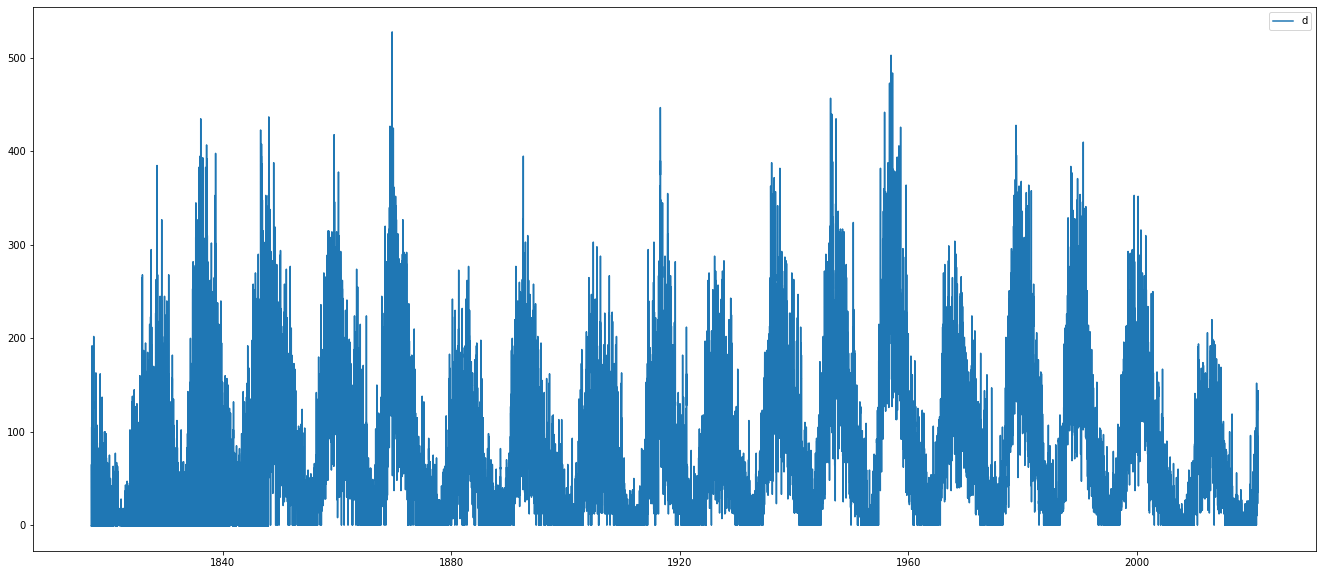

In [208]:
for thefile in global_dic:
  for col in global_dic[thefile].columns:
    if 'totalsunspot' in col.lower():
      plt.figure(figsize=(23,10))
      global_dic[thefile][col] = global_dic[thefile][col].astype(int)
      plt.plot(global_dic[thefile][col])
      plt.legend(col)

## a) Should the unit of time be day, then predict the of sunspots for 100/200/365 days into the future. 
## b) should the unit of time be month, then predict the of sunspots for 1/6/9 months into the future.
## c) Should the unit of time be year, then predict the of sunspots for 1/10/20 years into the future. 


In [209]:
global_dic['day_file'].reset_index(drop=False)[['date','dailyTotalSunspot']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74550 entries, 0 to 74549
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               74550 non-null  datetime64[ns]
 1   dailyTotalSunspot  74550 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.1 MB


In [210]:
model = Prophet(daily_seasonality=True)
predictions_dic = {}
for thefile in global_dic:
  for col in global_dic[thefile].columns:
    if col == 'dailyTotalSunspot':
      to_be_fitted = global_dic[thefile].reset_index(drop=False)[['date','dailyTotalSunspot']]
      print(to_be_fitted.info())
      to_be_fitted.rename(columns={'date':'ds',
                                   'dailyTotalSunspot':'y'},inplace=True)
      to_be_fitted['ds'] = pd.to_datetime(to_be_fitted['ds'])
      to_be_fitted['y'] = to_be_fitted['y'].astype(float)
      
      # model.fit(to_be_fitted)
      model.fit(to_be_fitted.iloc[-365*40:,:]) #keeping only the last 40 years' worth of data to fit the model
      for day in [100,200,365]:
        predictions_dic['day_'+str(day)] = model.make_future_dataframe(periods=day,freq='D')
        predictions_dic['prediction_'+str(day)] = model.predict(predictions_dic['day_'+str(day)])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74550 entries, 0 to 74549
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               74550 non-null  datetime64[ns]
 1   dailyTotalSunspot  74550 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.1 MB
None


In [211]:
# predictions_dic.keys()
for df in predictions_dic:
  if 'prediction' in df:
    print(df)
    print(predictions_dic[df].iloc[-5:,0:5])


prediction_100
              ds      trend  yhat_lower  yhat_upper  trend_lower
14695 2021-07-05  24.418184  -52.648679   43.366609    24.418184
14696 2021-07-06  24.388966  -53.529814   43.660634    24.388966
14697 2021-07-07  24.359747  -53.362508   44.494618    24.359747
14698 2021-07-08  24.330529  -53.092729   43.585045    24.330529
14699 2021-07-09  24.301311  -54.861689   42.345138    24.301311
prediction_200
              ds      trend  yhat_lower  yhat_upper  trend_lower
14795 2021-10-13  21.496353  -58.816954   39.639061    19.341199
14796 2021-10-14  21.467135  -61.716119   37.829501    19.299378
14797 2021-10-15  21.437917  -61.074277   39.547699    19.222601
14798 2021-10-16  21.408698  -60.200985   38.153960    19.175785
14799 2021-10-17  21.379480  -61.147913   38.875799    19.128969
prediction_365
              ds      trend  yhat_lower  yhat_upper  trend_lower
14960 2022-03-27  16.675333  -66.324943   36.473572     7.157861
14961 2022-03-28  16.646115  -66.374695   38.

prediction_100
prediction_200
prediction_365


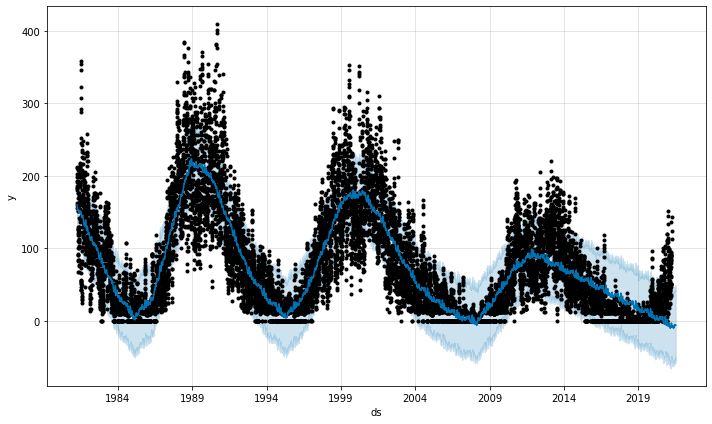

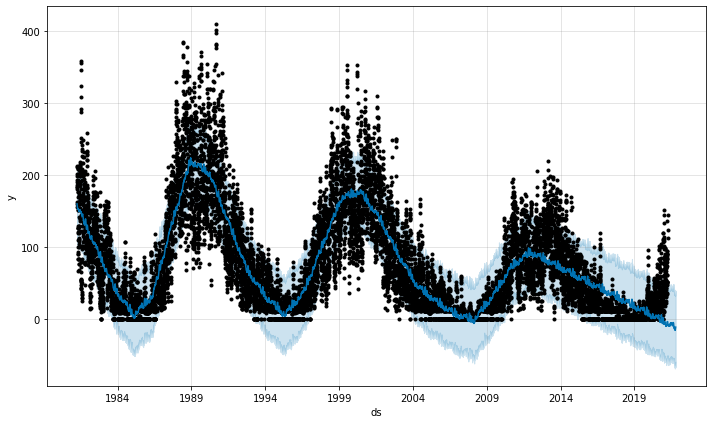

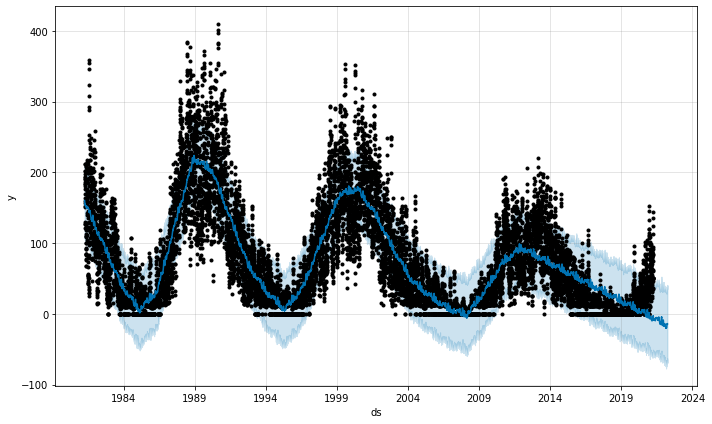

In [212]:
# predictions_dic.keys()
for df in predictions_dic:
  if 'prediction' in df:
    print(df)
    model.plot(predictions_dic[df], uncertainty=True)

prediction_100
prediction_200
prediction_365


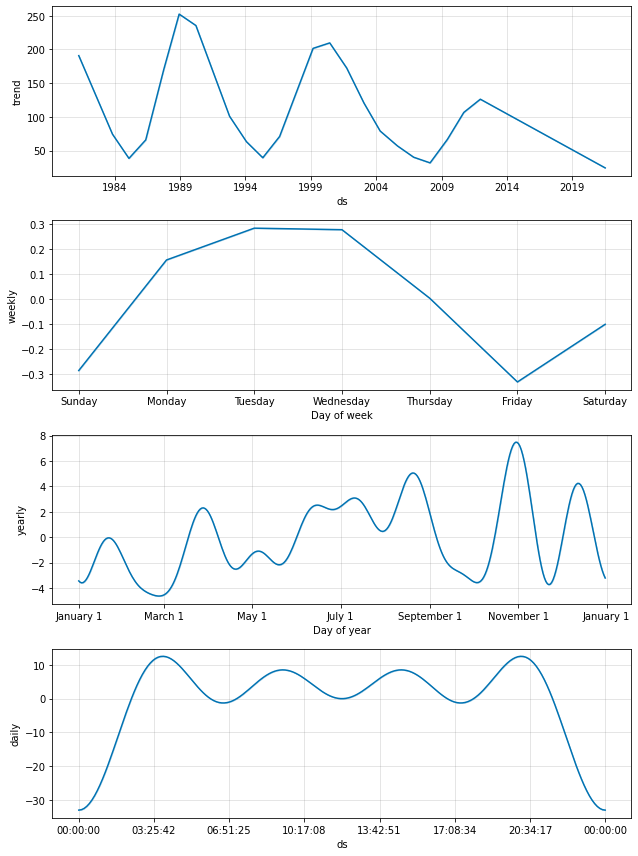

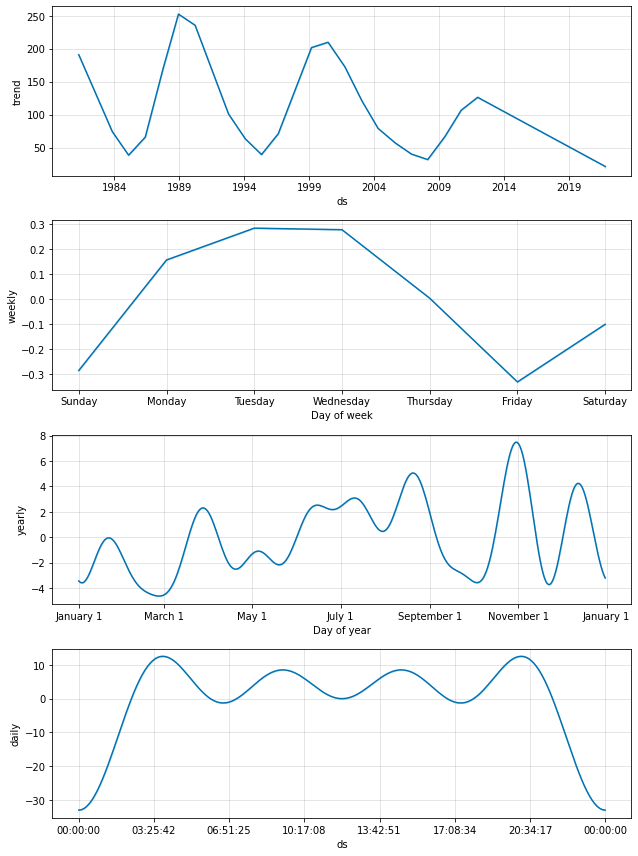

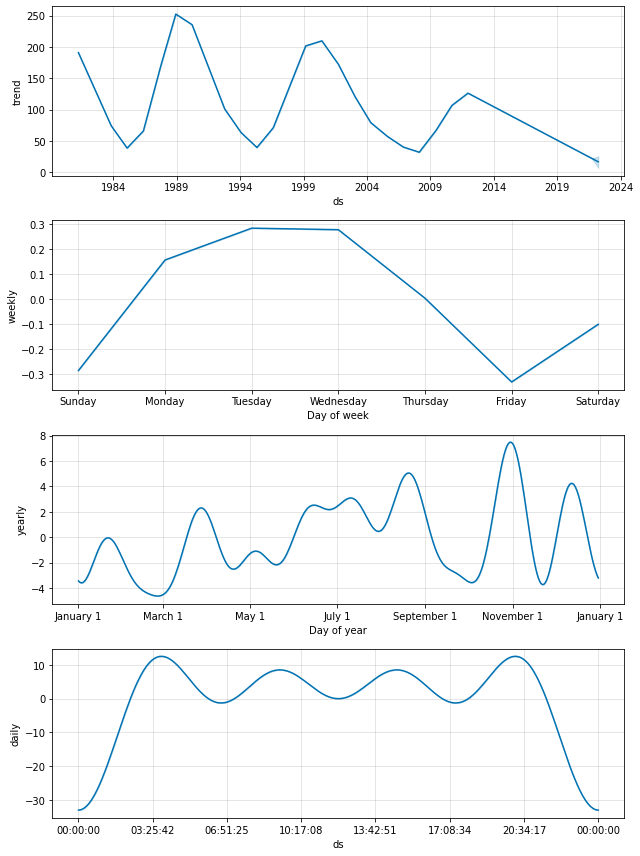

In [213]:
# predictions_dic.keys()
for df in predictions_dic:
  if 'prediction' in df:
    print(df)
    model.plot_components(predictions_dic[df])

# 3) Tune your FBProphet model on the following parameters:
## a) Forecasting growth: Plausible values = logistic; linear; flat
## b) Seasonality: Add manual seasonality by using the add_seasonality method. Test it with various values for ‘period’ and ‘fourier_order’.
## c) Trend Changepoints: Tune the ‘n_changepoints’ and ‘changepoit_prior_scale’ arguments/parameters

#4) Evaluate all models by providing their respective MAE (Mean Absolute Error) and MAPE (Mean Absolute Percentage Error), as well as R2 (use sklearn’s respective metrics).

In [214]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

logistic 10
logistic 20
logistic 30
linear 10
linear 20
linear 30
flat 10
flat 20
flat 30


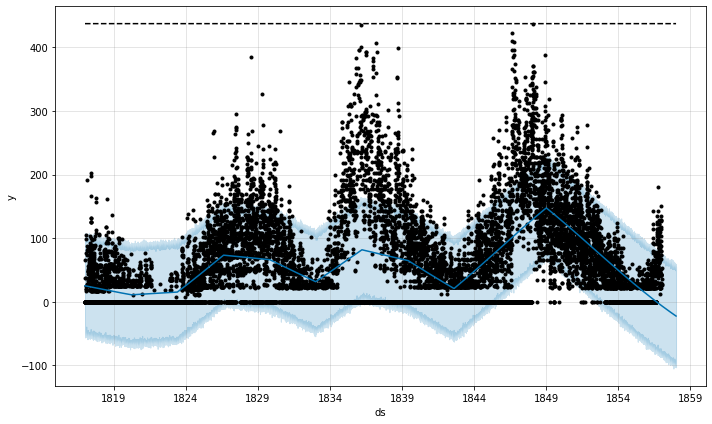

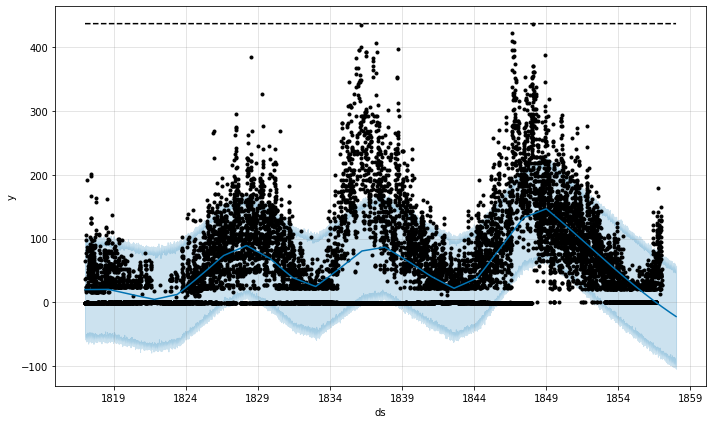

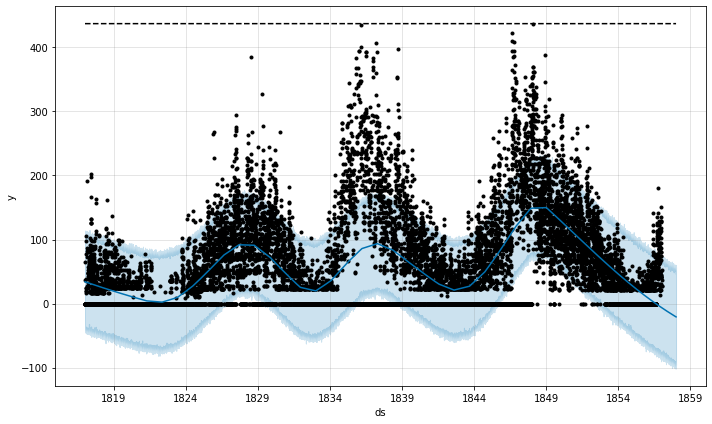

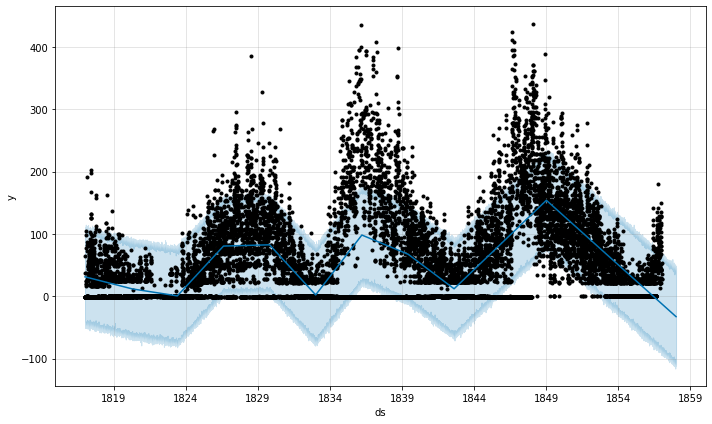

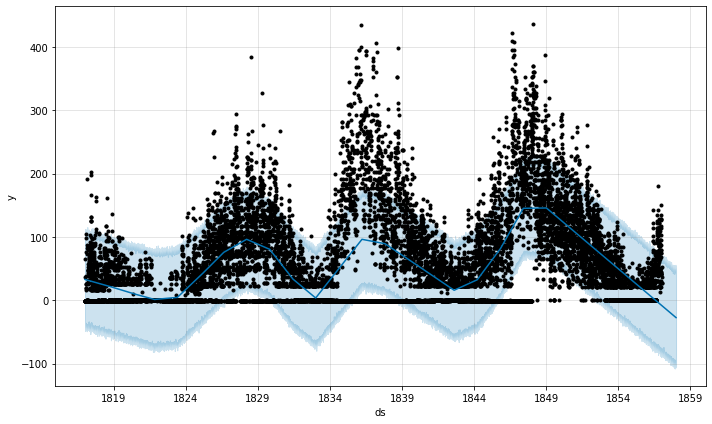

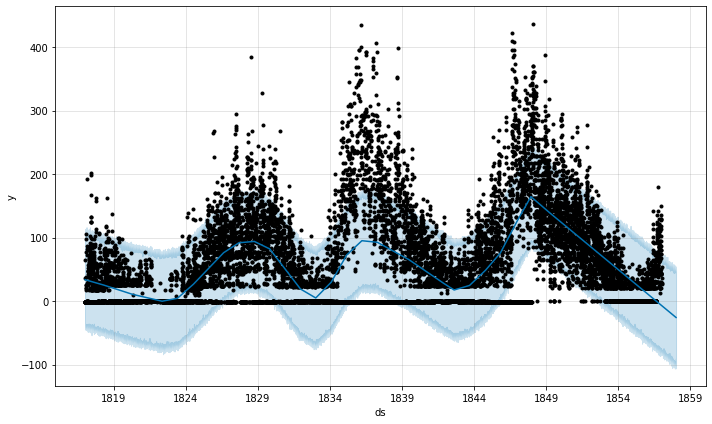

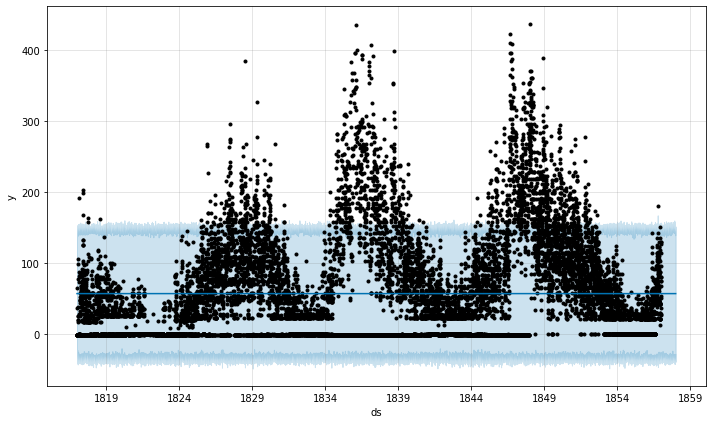

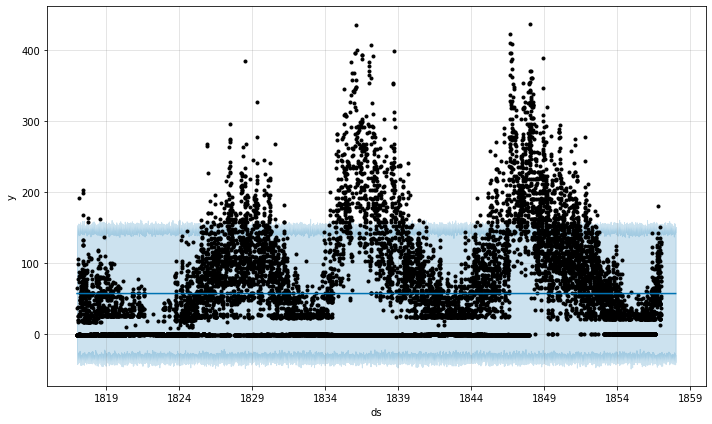

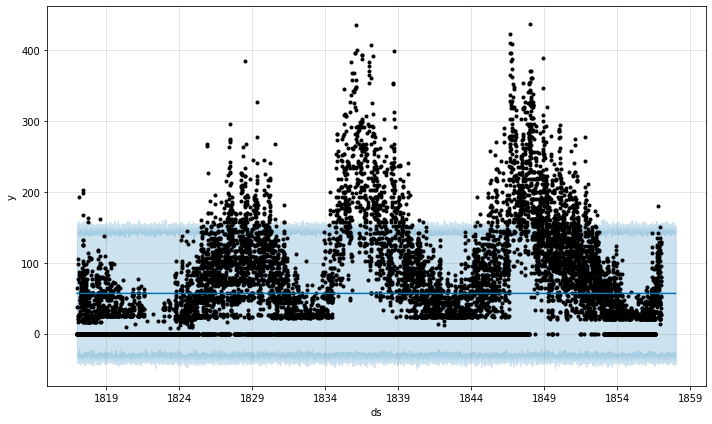

In [215]:
results = pd.DataFrame(columns = ['MAE','MAPE','R2','Growth','Value'])
to_be_fitted_cap = to_be_fitted.copy()
to_be_fitted_cap['cap'] = int(max(to_be_fitted.iloc[:365*40,1]))
for growth in ['logistic','linear','flat']:
  for value in [10,20,30]:
    model = Prophet(daily_seasonality=False,
                    weekly_seasonality=False,
                    yearly_seasonality=False,
                    growth=growth,
                    changepoint_prior_scale=value/100,
                    n_changepoints=value).add_seasonality(name='daily',
                                                          period=1,
                                                          fourier_order=value)
    if growth == 'logistic':
      model.fit(to_be_fitted_cap.iloc[:365*40,:]) #selecting the first 40 years of data to be fitted to the model
    else:
      model.fit(to_be_fitted.iloc[:365*40,:])

    future = model.make_future_dataframe(periods=365,freq='D')

    if growth == 'logistic':
      future['cap'] = int(max(to_be_fitted.iloc[:365*40,1]))

    prediction = model.predict(future)
    print(growth + ' ' + str(value))
    model.plot(prediction, uncertainty=True)
    results = results.append({'MAE':mean_absolute_error(to_be_fitted.iloc[(365*40):(365*41),1],prediction['yhat'][-365:]),
                              'MAPE':mean_absolute_percentage_error(to_be_fitted.iloc[(365*40):(365*41),1],prediction['yhat'][-365:]),
                              'R2':r2_score(to_be_fitted.iloc[(365*40):(365*41),1],prediction['yhat'][-365:]),
                              'Growth':growth,
                              'Value':value}, ignore_index=True)


In [216]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MAE     9 non-null      float64
 1   MAPE    9 non-null      float64
 2   R2      9 non-null      float64
 3   Growth  9 non-null      object 
 4   Value   9 non-null      object 
dtypes: float64(3), object(2)
memory usage: 488.0+ bytes


In [186]:
for col in ['MAE','MAPE','R2']:
  # if col == 'MAPE':
  #   results[col] = results[col].apply(lambda x: x/(10*14))
  results[col] = results[col].apply(lambda x: round(x,2))

In [187]:
results

,MAE,MAPE,R2,Growth,Value
0,118.83,1.533720e+12,-5.17,logistic,10
1,118.76,1.558063e+12,-5.16,logistic,20
2,118.21,1.534878e+12,-5.11,logistic,30
3,126.75,2.660008e+12,-5.90,linear,10
4,122.25,1.957599e+12,-5.49,linear,20
5,121.01,1.765874e+12,-5.38,linear,30
6,55.84,9.999360e+12,-0.82,flat,10
7,55.84,9.999360e+12,-0.82,flat,20
8,55.84,9.999360e+12,-0.82,flat,30
